In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

df_jo = pm.df('df_jo')
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

# Convertir columnas datetime a timestamps
for col in df_jo.select_dtypes(include=['datetime64']).columns:
    df_jo[col] = df_jo[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

for col in df_jo.select_dtypes(include=['timedelta64']).columns:
    df_jo[col] = df_jo[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

np.random.seed(42)

In [8]:
#VERIFICACION DE BALANCEO DE CLASES
from imblearn.under_sampling import RandomUnderSampler
value_counts_all = df_jo['needs_m_check_recov'].value_counts()
total_all = value_counts_all[0] + value_counts_all[1]
needs_manual_all = (value_counts_all[1] / total_all) * 100
print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')

# Separar características y variable objetivo
X = df_jo.drop(columns=['needs_m_check_recov'])  # Todas las columnas excepto la target
y = df_jo['needs_m_check_recov']  # Columna objetivo

# Instanciar RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Aplicar el muestreo
X_resampled, y_resampled = rus.fit_resample(X, y)

# Reconstruir un nuevo dataframe balanceado
df_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                          pd.DataFrame(y_resampled, columns=['needs_m_check_recov'])], axis=1)

# Verificar el balanceo
#print(f"{df_resampled.value_counts()}")
print(f"tamaño original: {len(df_jo)} tamaño balanceado: {len(df_balanced)}")
print(df_balanced['needs_m_check_recov'].value_counts())
df_jo = df_balanced



# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
#value_counts_all = df_jo['needs_m_check_recov'].value_counts()
#value_counts_new = new_users_df['needs_m_check_recov'].value_counts()
#value_counts_rep = repeat_users_df['needs_m_check_recov'].value_counts()

# Calcular el total de operaciones (suma de las dos categorías)
#total_all = value_counts_all[0] + value_counts_all[1]
#total_new = value_counts_new[0] + value_counts_new[1]
#total_rep = value_counts_rep[0] + value_counts_rep[1]

# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
#needs_manual_all = (value_counts_all[1] / total_all) * 100
#needs_manual_new = (value_counts_new[1] / total_new) * 100
#needs_manual_rep = (value_counts_rep[1] / total_rep) * 100

# Imprimir el resultado
#print(f'Porcentaje de operaciones con needs_m_check del total de clientes: {needs_manual_all:.2f} %')
#print(f'Porcentaje de operaciones con needs_m_check del clientes nuevos: {needs_manual_new:.2f} %')
#print(f'Porcentaje de operaciones con needs_m_check del clientes repetitivos: {needs_manual_rep:.2f} %')



Porcentaje de operaciones con needs_m_check del total de clientes: 52.31 %
tamaño original: 32092 tamaño balanceado: 30608
needs_m_check_recov
0    15304
1    15304
Name: count, dtype: int64


,amount,fee,n_backs,n_fees,n_inc_back,n_inc_fees,to_reimbur,type_incident,type_instant_payment,type_postpone,transfer_type_regular,category_nice,category_rejected_direct_debit,charge_moment_before
1,100.0,0.0,1,0,0,0,7.341954,0,0,0,1,0,0,0


,amount,fee,n_backs,n_fees,n_inc_back,n_inc_fees,to_reimbur,type_incident,type_instant_payment,type_postpone,transfer_type_regular,category_nice,category_rejected_direct_debit,charge_moment_before
1,0.634641,-1.394755,-0.343263,-0.877339,-0.517449,-0.490302,-1.083878,-0.26617,-0.744432,-0.558533,1.251596,-1.210457,-0.225411,-0.396598
7,0.634641,-1.394755,-0.343263,-0.877339,-0.517449,-0.490302,-0.459056,-0.26617,-0.744432,-0.558533,1.251596,-1.210457,-0.225411,-0.396598


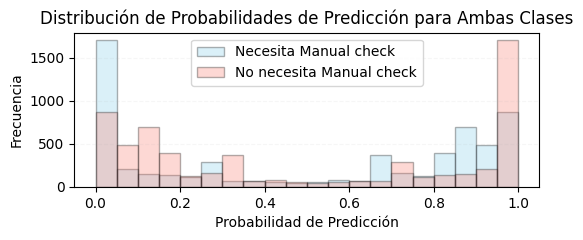

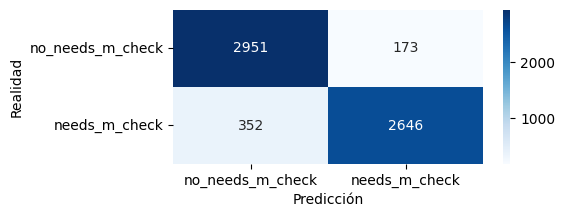

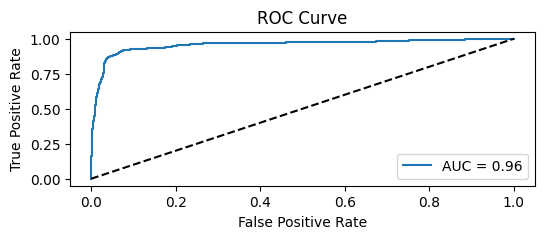

Accuracy: 0.9142437112054884
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92      3124
           1       0.94      0.88      0.91      2998

    accuracy                           0.91      6122
   macro avg       0.92      0.91      0.91      6122
weighted avg       0.92      0.91      0.91      6122

Coeficientes del modelo de regresión logística (ordenados por magnitud):
charge_moment_before: -3.4309
type_postpone: 3.0809
n_inc_fees: 2.9486
type_instant_payment: -2.2208
n_backs: -1.4734
type_incident: 1.2817
n_inc_back: 1.2181
transfer_type_regular: -1.1330
n_fees: -1.0606
category_rejected_direct_debit: 0.6395
fee: 0.5640
category_nice: 0.5048
amount: 0.1853
to_reimbur: -0.1793
predicciones_probabilidades:
 [[9.77900126e-01 2.20998744e-02]
 [8.16539253e-02 9.18346075e-01]
 [1.41045586e-01 8.58954414e-01]
 [9.02324910e-01 9.76750899e-02]
 [9.97369405e-01 2.63059466e-03]
 [4.66951020e-05 9.99953305e-01]
 [8.1

In [13]:
df_jo['moderada'] = df_jo['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Variables predictoras (ajusta según los datos disponibles)
#columnas = ['amount','fee','n_backs','n_fees','n_inc_back','n_inc_fees','to_reimbur', 'type', 'transfer_type','category','charge_moment'] #'user_id',   
#columnas = ['n_inc_back','n_inc_fees','n_recovery'] # 
#columnas = ['n_backs','n_fees','n_inc_back','n_inc_fees','n_cr_fe_m'] #
columnas = ['n_backs','n_fees','n_inc_fees','n_cr_fe_w', 'transfer_type'] 
X = df_jo[columnas].copy()

# Categoricas
#X = pd.get_dummies(X, columns=['type', 'transfer_type', 'category','charge_moment'], drop_first=True, dtype =int)
X = pd.get_dummies(X, columns=['transfer_type'], drop_first=True, dtype =int)


columnas = ['amount','fee','n_backs','n_fees','n_inc_back','n_inc_fees','to_reimbur', 'type', 'transfer_type','category','charge_moment'] #'user_id',   
X = df_jo[columnas].copy()
# Categoricas
X = pd.get_dummies(X, columns=['type', 'transfer_type', 'category','charge_moment'], drop_first=True, dtype =int)


# Crear el escalador
display(X.head(1))
scaler = StandardScaler()
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X.columns, index=df_jo.index)
X.fillna(0, inplace=True)
#X.info()



y = df_jo['needs_m_check_recov'].copy()  #moderada # La columna de la variable objetivo
display(X.head(2))




feature_names = X.columns # Obtener los nombres de las características
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")
clf.fit(X_train, y_train) # Entrena el clasificador
predicciones = clf.predict(X_test) # Realiza predicciones sobre el conjunto de prueba

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(6, 2)) 
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(5, 2))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, predicciones_probabilidades[:, 1])
plt.figure(figsize=(6, 2))
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report


# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Muestra las primeras 10 probabilidades de predicción
print(f"predicciones_probabilidades:\n {predicciones_probabilidades[:10]}\n")


Total de muestras: 500
500


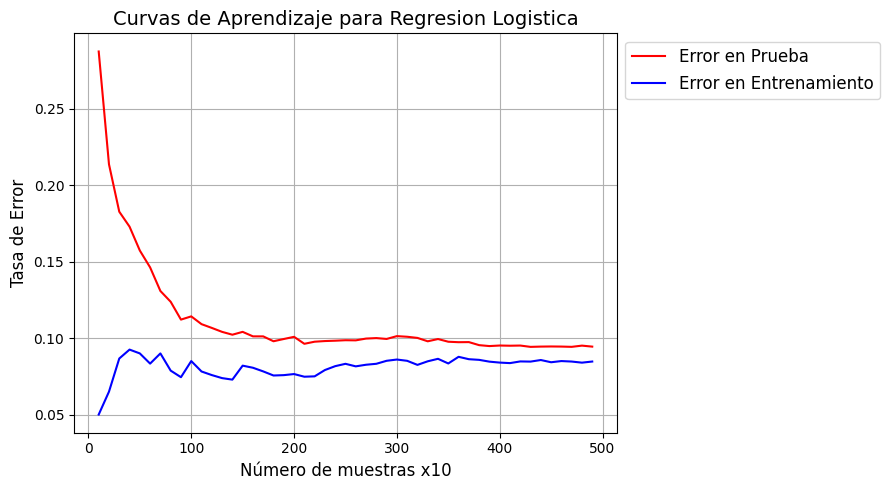

In [14]:
# Parámetros
MAXN = 500 # len(X)  # Total de muestras disponibles
steps = 10  # Tamaño de incremento del conjunto de entrenamiento
iterations = 10  # Número de iteraciones para suavizar los resultados
print(f"Total de muestras: {MAXN}")

print(f"{(MAXN // steps) * steps + 0 }")

# Calcular el número de columnas
cols = list(range(steps, (MAXN // steps) * steps, steps))

# Inicializamos los DataFrames para almacenar los errores
test_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)
train_errors = pd.DataFrame(np.zeros((iterations, len(cols))), columns=cols)

# Generamos los errores promedios por iteración
for iteration in range(iterations):
    # Mezclamos los datos
    data = pd.concat([X, y], axis=1).sample(frac=1).reset_index(drop=True)
    X_shuffled = data[X.columns]
    y_shuffled = data[y.name]
    
    for N in range(steps, MAXN, steps):
        j = (N // steps) - 1  # Índice para almacenar resultados
        
        # Tomar un subconjunto de datos para entrenamiento
        X_subset = X_shuffled.iloc[:N, :]
        y_subset = y_shuffled.iloc[:N]
        
        # Crear y entrenar el modelo de regresión logística
        clf = LogisticRegression(solver="liblinear", max_iter=1000)
        clf.fit(X_subset, y_subset)
        
        # Evaluar el modelo en el conjunto de prueba y calcular la tasa de error.
        test_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_test), y_test)
        # Evaluar el modelo en el conjunto de entrenamiento y calcular la tasa de error.
        train_errors.iloc[iteration, j] = 1 - metrics.accuracy_score(clf.predict(X_subset), y_subset)

# Promediar las tasas de error a lo largo de las iteraciones para obtener una curva de aprendizaje más estable.
mean_test_error = test_errors.mean(axis=0)
mean_train_error = train_errors.mean(axis=0)

# Graficar las curvas de aprendizaje: tasa de error en prueba y entrenamiento.
plt.figure(figsize=(9, 5))
plt.plot(mean_test_error, 'r', label='Error en Prueba') # Error en el conjunto de prueba.
plt.plot(mean_train_error, 'b', label='Error en Entrenamiento') # Error en el conjunto de entrenamiento.

# Configurar etiquetas, título y leyenda.
plt.xlabel('Número de muestras x10', fontsize=12)
plt.ylabel('Tasa de Error', fontsize=12)
plt.title('Curvas de Aprendizaje para Regresion Logistica', fontsize=14)
plt.legend(loc='upper left', fontsize=12, bbox_to_anchor=(1, 1))

# Mostrar la gráfica con las curvas de error.
plt.grid(True)
plt.tight_layout() # Ajustar la distribución para evitar que las etiquetas se corten.
plt.show()